# Get surface of 3d object

In [1]:
# import library
import math
import random as rng
import os
import cv2 as cv
import cv2
import numpy as np
import pygame
import os
from concurrent.futures import ThreadPoolExecutor
import queue
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pygame 2.3.0 (SDL 2.24.2, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
def distancePoint(p1, p2):
    # find distance between 2 points
    a = (p1[0] - p2[0]) * (p1[0] - p2[0])
    b = (p1[1] - p2[1]) * (p1[1] - p2[1])
    return math.sqrt(a + b)


def findSlope(p, q):
    # Find slope and intercept
    if p[1] == q[1]:
        slope = 0
    elif p[0] == q[0]:
        slope = 1e9
    else:
        slope = (q[1] - p[1]) / (q[0] - p[0])
    intercept = p[1] - slope * p[0]
    return slope, intercept

def convert_hull(points):
    count = np.array(points, dtype=np.int32)
    arr = []
    for i in range(count.shape[0]):
        arr.append([count[i][0][0], count[i][0][1]])
    return arr

def convert_shape(points):
    count = np.array(points, dtype=np.int32)
    arr = []
    for i in range(count.shape[0]):
        arr.append([count[i][0][0], count[i][0][1]])
    return arr

def check_shape(src):
    gp_thres = 20
    src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(src, 100, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros((src.shape[0], src.shape[1], 3), dtype=np.uint8)
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])
        if area >= 0.2 * src.shape[0] * src.shape[1]:
            color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
            cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= 0.2 * src.shape[0] * src.shape[1]:
            # gives area of contour
            perimeter = cv2.arcLength(contour, closed=True)
            borders = cv2.approxPolyDP(curve=contour, epsilon=0.01 * perimeter, closed=False)
            borders = convert_hull(borders)

            temp = borders
            temp.append(borders[0])
            temp.append(borders[1])
            temp.append(borders[2])
            corners_check_shape = []
            arr_same_line = []
            for i in range(len(temp) - 1):

                if i + 2 < len(temp):
                    a = temp[i]
                    b = temp[i + 1]
                    c = temp[i + 2]

                    slope1, _ = findSlope(a, b)
                    slope2, _ = findSlope(b, c)
                    if abs((a[0] * (b[1] - c[1]) + b[0] * (c[1] - a[1]) + c[0] * (a[1] - b[1]))) <= 0.02 * src.shape[
                        0] * src.shape[1]:
                        if len(arr_same_line) > 0:
                            a1 = arr_same_line[0]
                            b1 = temp[i + 1]
                            c1 = temp[i + 2]
                            if abs((a1[0] * (b1[1] - c1[1]) + b1[0] * (c1[1] - a1[1]) + c1[0] * (
                                    a1[1] - b1[1]))) > 0.02 * src.shape[0] * src.shape[1]:
                                corners_check_shape.append(arr_same_line[0])

                                arr_same_line = [temp[i + 1]]
                        else:
                            if temp[i] not in corners_check_shape:
                                arr_same_line.append(temp[i])
                    else:
                        if temp[i] not in arr_same_line:
                            arr_same_line.append(temp[i])
                        if len(arr_same_line) > 0:
                            if arr_same_line[0] not in corners_check_shape:
                                corners_check_shape.append(arr_same_line[0])
                            for k in range(1, len(arr_same_line)):
                                if arr_same_line[k] in corners_check_shape:
                                    corners_check_shape.remove(arr_same_line[k])
                            arr_same_line = []
                        else:
                            if temp[i] not in corners_check_shape:
                                corners_check_shape.append(temp[i])
                else:
                    if len(arr_same_line) > 0:
                        if arr_same_line[0] not in corners_check_shape:
                            corners_check_shape.append(arr_same_line[0])
                        arr_same_line = []
                    else:
                        if temp[i] not in corners_check_shape:
                            corners_check_shape.append(temp[i])
            temp = corners_check_shape
            corners_check_shape = []
            dict_label = {}
            flag = [0] * len(temp)
            for i in range(len(temp)):
                for j in range(i + 1, len(temp)):
                    dis = distancePoint(temp[i], temp[j])
                    if dis <= gp_thres:
                        flag[i] = i + 1
                        flag[j] = i + 1
            for i in range(len(temp)):
                if flag[i] == 0:

                    corners_check_shape.append(temp[i])
                elif flag[i] < 1e9:
                    cnt = 1
                    p = temp[i]

                    for j in range(i + 1, len(temp)):
                        if flag[i] == flag[j]:
                            p[0] += temp[j][0]
                            p[1] += temp[j][1]
                            cnt += 1
                            flag[j] = 1e9
                    p[0] = int(p[0] / cnt)
                    p[1] = int(p[1] / cnt)
                    flag[i] = 1e9
                    corners_check_shape.append(p)
            color = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
            # for corner in corners_check_shape:
            #     cv.circle(drawing, (corner[0], corner[1]), 3, color, -1)
            return corners_check_shape, drawing
    return None


#
# def mainfunc(f):
#     """Old main function"""
#     path = 'dataset/train/'
#     path_seg = 'dataset/segmentation_labels/'
#     name = f.split('.')
#     src_color = cv2.imread(cv2.samples.findFile(path + f))
#     default_file = path_seg + name[0] + '_seg.' + name[1]
#     src = cv2.imread(cv2.samples.findFile(default_file))
#     corners_check_shape, corners = check_shape(src)
#     src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
#     _, src = cv2.threshold(src, 128, 1, cv2.THRESH_BINARY)
#     cropt = cv2.bitwise_and(src_color, src_color, mask=src)
#     src *= 255
#
#
# if __name__ == "__main__":
#     path_main = 'dataset/train/'
#     files = os.listdir(path_main)
#     shape_7 = queue.PriorityQueue()
#     # for f in range(10):
#     #     mainfunc(files[f])
#     with ThreadPoolExecutor() as executor:
#         for f in files:
#             executor.submit(mainfunc, f)




In [2]:
def draw_intersect(mask, img, corners, intersect_1, intersect_2):
    color1 = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))
    color2 = (rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256))

    #draw intersect
    cv2.circle(mask, (intersect_1[0], intersect_1[1]), 3, color1, -1)
    cv2.circle(mask, (intersect_2[0], intersect_2[1]), 3, color2, -1)
    cv2.circle(img, (intersect_1[0], intersect_1[1]), 3, color1, -1)
    cv2.circle(img, (intersect_2[0], intersect_2[1]), 3, color2, -1)

    # text
    cv2.putText(mask, '1', intersect_1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color1, 2, cv2.LINE_AA)
    cv2.putText(mask, '2', intersect_2, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color2, 2, cv2.LINE_AA)

    #draw lines
    #intersect 1
    cv2.line(mask, corners[1], intersect_1, color1, 2)
    cv2.line(mask, corners[3], intersect_1, color1, 2)
    cv2.line(mask, corners[5], intersect_1, color1, 2)
    #intersect 2
    cv2.line(mask, corners[0], intersect_2, color2, 2)
    cv2.line(mask, corners[2], intersect_2, color2, 2)
    cv2.line(mask, corners[4], intersect_2, color2, 2)

def cv_imread(file_path):
    cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), 1)
    return cv_img

def find_intersect(slop1, point1, slop2, point2):
    b1 = point1[1] - slop1*point1[0]
    b2 = point2[1] - slop2*point2[0]
    x = (b1 - b2)/(slop2 - slop1)
    y = slop1 * x + b1
    return np.array([int(x), int(y)])

def img_intersect(corners):
    output_size = 640
    # parallel:
    # 1:  0&1 -> 3&4
    # 2:  1&2 -> 4&5
    # 3:  2&3 -> 5&0

    slop_1 = (findSlope(corners[0], corners[1])[0] + findSlope(corners[3], corners[4])[0])/2
    slop_2 = (findSlope(corners[1], corners[2])[0] + findSlope(corners[4], corners[5])[0])/2
    slop_3 = (findSlope(corners[2], corners[3])[0] + findSlope(corners[5], corners[0])[0])/2

    intersect1 = list((find_intersect(slop_1, corners[5], slop_2, corners[3])
                       + find_intersect(slop_1, corners[5], slop_3, corners[1])
                       + find_intersect(slop_2, corners[3], slop_3, corners[1])) / 3)

    intersect2 = list((find_intersect(slop_1, corners[2], slop_2, corners[0])
                       + find_intersect(slop_1, corners[2], slop_3, corners[4])
                       + find_intersect(slop_3, corners[4], slop_2, corners[0])) / 3)
    return (int(intersect1[0]), int(intersect1[1])), (int(intersect2[0]), int(intersect2[1]))

def in_x(w, x, padding_size):
    if x + padding_size > w-1 or x - padding_size < 1:
        return False
    else:
        return True

def in_y(h, y, padding_size):
    if y + padding_size > h-1 or y - padding_size < 1:
        return False
    else:
        return True

def get_region(img, intersect_1, intersect_2, window_size):
    h, w, _ = img.shape
    region_1 = img[(intersect_1[1] - int(window_size/2) if in_x(w, intersect_1[1] - int(window_size/2), window_size/2) else 1) :
                   (intersect_1[1] + int(window_size/2) if in_x(w, intersect_1[1] + int(window_size/2), window_size/2) else w-1), :]
    region_1 = region_1[:, (intersect_1[0] - int(window_size/2) if in_y(h, intersect_1[0] - int(window_size/2), window_size/2) else 1) :
                           (intersect_1[0] + int(window_size/2) if in_y(h, intersect_1[0] + int(window_size/2), window_size/2) else h-1)]

    region_2 = img[(intersect_2[1] - int(window_size/2) if in_x(w, intersect_2[1] - int(window_size/2), window_size/2) else 1) :
                   (intersect_2[1] + int(window_size/2) if in_x(w, intersect_2[1] + int(window_size/2), window_size/2) else w-1), :]
    region_2 = region_2[:, (intersect_2[0] - int(window_size/2) if in_y(h, intersect_2[0] - int(window_size/2), window_size/2) else 1) :
                           (intersect_2[0] + int(window_size/2) if in_y(h, intersect_2[0] + int(window_size/2), window_size/2) else h-1)]

    return region_1, region_2

def get_surface(corners, intersect_1, intersect_2):
    #get surface 1
    surface_1 = []
    surface_1.append([corners[1], corners[0], intersect_1, corners[5]])
    surface_1.append([corners[2], corners[1], corners[3], intersect_1])
    surface_1.append([corners[5], corners[4], intersect_1, corners[3]])
    #get surface 2
    surface_2 = []
    surface_2.append([corners[1], corners[0], corners[2], intersect_2])
    surface_2.append([corners[3], corners[2], corners[4], intersect_2])
    surface_2.append([corners[5], corners[4], corners[0], intersect_2])

    return surface_1, surface_2

def crop_surface(surface, img, output_size):
    pts = np.float32([[0,0],[output_size,0],[0,output_size],[output_size, output_size]])

    output = [
        cv2.warpPerspective(img,cv2.getPerspectiveTransform(np.array(surface[0]).astype(np.float32),pts),(output_size,output_size)),
        cv2.warpPerspective(img,cv2.getPerspectiveTransform(np.array(surface[1]).astype(np.float32),pts),(output_size,output_size)),
        cv2.warpPerspective(img,cv2.getPerspectiveTransform(np.array(surface[2]).astype(np.float32),pts),(output_size,output_size)),
    ]
    return output

def get_variance_rgb(img):
    b,g,r = cv2.split(img)
    var_r = np.var(np.array(r).flatten())
    var_g = np.var(np.array(r).flatten())
    var_b = np.var(np.array(r).flatten())
    return np.array([var_r, var_g, var_b])

def get_angle(lines):
    angles = []
    if lines is not None:
        for line in lines:
            if line is not None:
                rho, theta = line[0]
                angle = theta * 180 / np.pi
                if (80 > angle > 10) or (170 > angle > 100):
                    angles.append(angle)
        return angles
    else:
        return None

def normalize_in_mask_rgb(img, mask):
    img_copy = img.copy()

    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask = cv2.threshold(mask, 125, 255, cv2.THRESH_BINARY)[1]
    mask = mask[:, :, None] * np.ones(3, dtype=int)[None, None, :]
    mask = (mask > 125)*1

    img_copy = img_copy.astype(np.float32)
    mask = mask.astype(np.float32)
    masked_img = img_copy * mask

    # Calculate mean and standard deviation of pixel values in masked region
    mean, std = cv2.meanStdDev(masked_img)

    #normalized_img = cv2.divide(cv2.subtract(masked_img, mean), std)
    # Reshape image to 2D array
    img_2d = masked_img.reshape(-1, 3)
    # Subtract values from each channel of the image
    subtracted_img = (img_2d - mean.reshape(1,3))/ std.reshape(1,3)

    # Reshape subtracted image to original shape
    normalized_img = subtracted_img.reshape(img.shape)

    img_copy = mask * normalized_img *255
    img_copy = img_copy.astype(np.uint8)
    return img_copy

def normalize_in_mask(img, mask):
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

    # Normalize image inside the mask
    masked_img = cv2.bitwise_and(img, mask)
    mean, std = cv2.meanStdDev(masked_img)
    normalized_img = cv2.divide(cv2.subtract(masked_img, mean), std)

    # Scale the normalized image to the range 50 to 255
    normalized_img = cv2.normalize(normalized_img, None, 80, 255, cv2.NORM_MINMAX)

    return normalized_img


In [210]:
def cut_img_var(mask, img, corners):
    window_ratio = 0.05
    _resize = (50,50)
    w, h, _ = img.shape
    output_size = 448

    img_copy = img.copy()
    #img_copy = normalize_in_mask_rgb(img_copy, mask)
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2HSV)
    img_copy = cv2.GaussianBlur(img_copy, (5,5), 0)

    intersect_1, intersect_2 = img_intersect(corners)

    draw_intersect(mask, img, corners, intersect_1, intersect_2)
    region_1, region_2 = get_region(img_copy, intersect_1, intersect_2, window_size= int(np.sqrt(window_ratio*w*h)))

    region_1 = cv2.resize(region_1, dsize = _resize)
    region_2 = cv2.resize(region_2, dsize = _resize)

    region_1 = cv2.bilateralFilter(region_1, 9, 125, 125, cv2.BORDER_DEFAULT)
    region_2 = cv2.bilateralFilter(region_2, 9, 125, 125, cv2.BORDER_DEFAULT)

    decision = get_variance_rgb(region_1) > get_variance_rgb(region_2)
    #print(get_variance_rgb(region_1), get_variance_rgb(region_2))
    #print(decision)
    surface = []
    surface_1, surface_2 = get_surface(corners, intersect_1, intersect_2)
    if sum(decision) >=2:
        #region 1 true
        surface = surface_1
    else:
        #region 2 true
        surface = surface_2

    output = crop_surface(surface, img, output_size)

    #print(np.sum(np.array(edges_1).flatten()), np.sum(np.array(edges_2).flatten()))
    #return edges_1, edges_2, output[0]
    return region_1, region_2, output[0]
    #return output
    #return region_1, region_2
    #return edges_1, edges_2, cv2.cvtColor(output[0], cv2.COLOR_RGB2GRAY)


def cut_img_surface(mask, img, corners):
    output_size = 30
    crop_out = 0.1
    zoom_out_size = (90,90)

    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)

    intersect_1, intersect_2 = img_intersect(corners)
    draw_intersect(mask, img, corners, intersect_1, intersect_2)

    surface_1, surface_2 = get_surface(corners, intersect_1, intersect_2)

    #result
    result_1 = crop_surface(surface_1, img, 800)
    result_2 = crop_surface(surface_2, img, 800)
    #crop surface
    crop_1 = crop_surface(surface_1, v, output_size)
    crop_2 = crop_surface(surface_2, v, output_size)

    #crop border
    crop_size = int(output_size*crop_out)
    for i in range(3):
        crop_1[i] = crop_1[i][crop_size:output_size-crop_size, crop_size:output_size-crop_size]
        crop_2[i] = crop_2[i][crop_size:output_size-crop_size, crop_size:output_size-crop_size]

    #normalize -> blur -> resize -> sharpen
    s_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    for i in range(3):
        #normalize
        crop_1[i] = cv2.normalize(crop_1[i], None, 0, 255, cv2.NORM_MINMAX)
        crop_2[i] = cv2.normalize(crop_2[i], None, 0, 255, cv2.NORM_MINMAX)

        #blur
        crop_1[i] = cv2.bilateralFilter(crop_1[i], 9, 125, 125, cv2.BORDER_DEFAULT)
        crop_1[i] = cv2.filter2D(crop_1[i], -1, s_kernel)
        crop_1[i] = cv2.resize(crop_1[i], dsize = zoom_out_size, interpolation=cv2.INTER_CUBIC)
        crop_1[i] = cv2.bilateralFilter(crop_1[i], 9, 125, 125, cv2.BORDER_DEFAULT)

        crop_2[i] = cv2.bilateralFilter(crop_2[i], 9, 125, 125, cv2.BORDER_DEFAULT)
        crop_2[i] = cv2.filter2D(crop_2[i], -1, s_kernel)
        crop_2[i] = cv2.resize(crop_2[i], dsize = zoom_out_size, interpolation=cv2.INTER_CUBIC)
        crop_2[i] = cv2.bilateralFilter(crop_2[i], 9, 125, 125, cv2.BORDER_DEFAULT)

    #get edges
    edge_1, edge_2 = [], []
    angles_1, angles_2 = [], []

    for i in range(3):
        #surface 1
        edge_1.append(cv2.Canny(crop_1[i], 50, 80))
        line_1 = cv2.HoughLines(edge_1[i], rho=1, theta=np.pi/90, threshold=35)
        angles_1.append(get_angle(line_1))

        #surface 2
        edge_2.append(cv2.Canny(crop_2[i], 50, 80))
        line_2 = cv2.HoughLines(edge_2[i], rho=1, theta=np.pi/90, threshold=35)
        angles_2.append(get_angle(line_2))

    num_ang_1, num_ang_2 = sum(1 for sublist in angles_1 if sublist is not None for element in sublist), sum(1 for sublist in angles_2 if sublist is not None for element in sublist)
    #
    #

    if num_ang_1 > num_ang_2:
        return result_2
    elif num_ang_1 == num_ang_2:
        return 0
    else:
        return result_1

    # print(angles_1, angles_2)
    # print(num_ang_1, num_ang_2)
    #
    # if num_ang_1 > num_ang_2:
    #     print('choose 2')
    # elif num_ang_1 == num_ang_2:
    #     print('do not know')
    # else:
    #     print('choose 1')
    #
    # return edge_1, edge_2

In [6]:
def matching(img, matching_set):
    matching_score = 0
    for object in matching_set:
        object = cv2.cvtColor(object, cv2.COLOR_BGR2HSV)
        _h, _s, _v = cv2.split(object)
        _v = cv2.normalize(_v, None, 0, 255, cv2.NORM_MINMAX)

        sift = cv2.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(img,None)
        kp2, des2 = sift.detectAndCompute(_v,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
        matching_score += len(good)
    return matching_score


def cut_img_matching(img, corners, sample_set):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    output_size = 600

    intersect_1, intersect_2 = img_intersect(corners)
    #draw_intersect(mask, img, corners, intersect_1, intersect_2)
    surface_1, surface_2 = get_surface(corners, intersect_1, intersect_2)
    
    #result
    result_1 = crop_surface(surface_1, img, output_size)
    result_2 = crop_surface(surface_2, img, output_size)
    
    #crop surface
    crop_1 = crop_surface(surface_1, v, output_size)
    crop_2 = crop_surface(surface_2, v, output_size)

    #normalize
    for i in range(3):
        crop_1[i] = cv2.normalize(crop_1[i], None, 0, 255, cv2.NORM_MINMAX)
        crop_2[i] = cv2.normalize(crop_2[i], None, 0, 255, cv2.NORM_MINMAX)

    #matching
    matching_1, matching_2 = 0,0
    for i in range(3):
        matching_1+= matching(crop_1[i], sample_set)
        matching_2+= matching(crop_2[i], sample_set)

    if matching_1 > matching_2:
        return result_1
    else:
        return result_2


In [20]:
# Parameters for SIFT feature extraction
sift = cv2.SIFT_create()

# Parameters for K-means clustering
K = 6 # Number of clusters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS

# Load images
img_dir = 'classify/box/crop_by_surface_2/croped'
img_names = os.listdir(img_dir)[:1000]
imgs = [cv2.imread(os.path.join(img_dir, img_name), cv2.IMREAD_GRAYSCALE) for img_name in img_names]

# Extract features using SIFT
kp_list = []
des_list = []
for img in imgs:
    kp, des = sift.detectAndCompute(img, None)
    kp_list.append(kp)
    des_list.append(des)

# Stack descriptors into a numpy array
descriptors = np.vstack(des_list)

# Cluster descriptors using K-means
compactness, labels, centers = cv2.kmeans(descriptors, K, None, criteria, 10, flags)

# Create directories for each cluster
for i in range(K):
    os.makedirs(os.path.join(img_dir, f'cluster_{i}'), exist_ok=True)

# Assign images to clusters based on their labels
for img_name, img, label in zip(img_names, imgs, labels):
    cluster_dir = os.path.join(img_dir, f'cluster_{label[0]}')
    cv2.imwrite(os.path.join(cluster_dir, img_name), img)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 128 and the array at index 194 has size 1

In [111]:
def test_9(img_name):
    src_img = cv2.imread('classify/box/seg/'+img_name)
    img = cv2.imread('classify/box/label/'+img_name)
    plt.set_cmap("gray")

    plt.figure(figsize = [10, 12])
    print(img.shape)
    corners = check_shape(img)
    print(corners[0])

    if len(corners[0]) == 6:
        cut = cut_img_surface(img, src_img, corners[0])
        plt.subplot(331); plt.imshow(src_img[:,:,::-1]); plt.title('Origin Image')
        plt.subplot(332); plt.imshow(img[:,:,::-1]); plt.title('Mask Image')
        plt.subplot(333); plt.imshow(corners[1][:,:,    ::-1]); plt.title("Synh's Image")
        plt.subplot(334); plt.imshow(cut[0][0][:,:]); plt.title('Surface1_0')
        plt.subplot(335); plt.imshow(cut[0][1][:,:]); plt.title('Surface1_1')
        plt.subplot(336); plt.imshow(cut[0][2][:,:]); plt.title('Surface1_2')
        plt.subplot(337); plt.imshow(cut[1][0][:,:]); plt.title('Surface2_0')
        plt.subplot(338); plt.imshow(cut[1][1][:,:]); plt.title('Surface2_1')
        plt.subplot(339); plt.imshow(cut[1][2][:,:]); plt.title('Surface2_2')


(280, 230, 3)
[[61, 5], [0, 87], [49, 266], [188, 274], [229, 190], [194, 8]]
[[], [], [31.999999752116263]] [[118.00000100691943, 118.00000100691943, 115.99999867453464], [154.0000020087107, 151.9999996763259, 156.0000043410955], [133.9999923452411, 135.9999946776259, 137.99999701001067]]
1 9
choose 1


<Figure size 640x480 with 0 Axes>

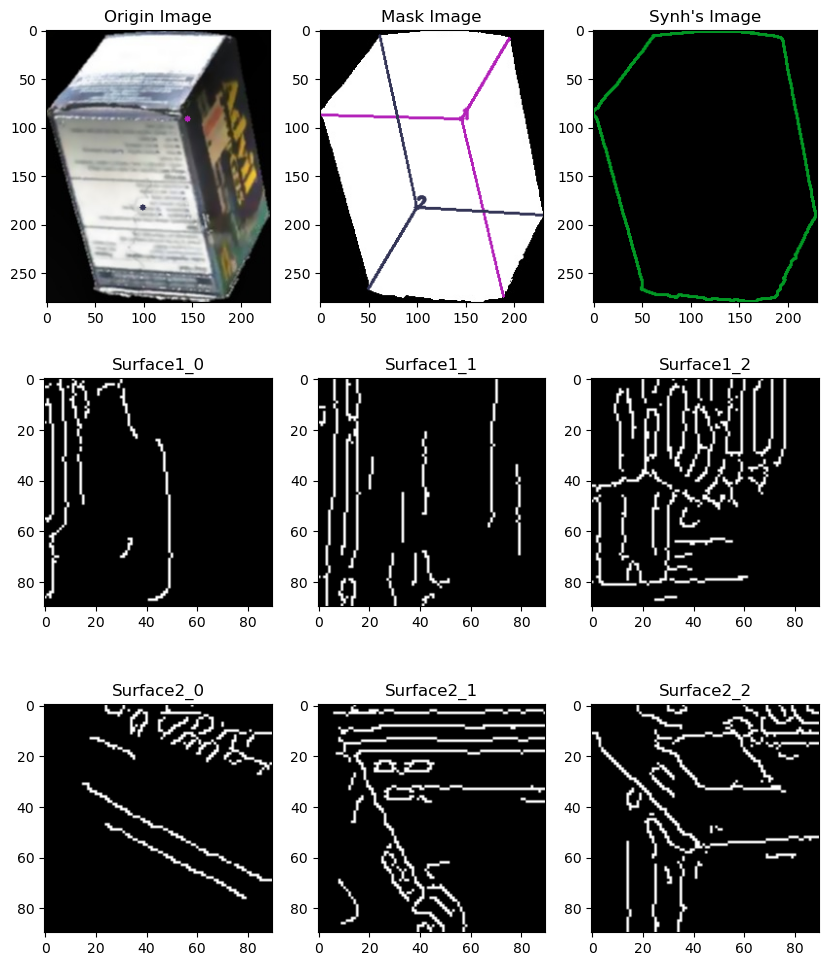

In [207]:
img_name = '00001_117.jpg'
test_9(img_name)

In [7]:
def test_matching(img_name, sample):
    src_img = cv2.imread('classify/box/seg/'+img_name)
    img = cv2.imread('classify/box/label/'+img_name)

    plt.set_cmap("gray")
    plt.figure(figsize = [10, 12])
    corners = check_shape(img)

    if len(corners[0]) == 6:
        cut = cut_img_matching(src_img, corners[0], sample)
        plt.subplot(331); plt.imshow(src_img[:,:,::-1]); plt.title('Origin Image')
        plt.subplot(332); plt.imshow(img[:,:,::-1]); plt.title('Mask Image')
        plt.subplot(333); plt.imshow(corners[1][:,:,    ::-1]); plt.title("Synh's Image")
        plt.subplot(334); plt.imshow(cut[0][:,:]); plt.title('Surface1_0')
        plt.subplot(335); plt.imshow(cut[1][:,:]); plt.title('Surface1_1')
        plt.subplot(336); plt.imshow(cut[2][:,:]); plt.title('Surface1_2')

<Figure size 640x480 with 0 Axes>

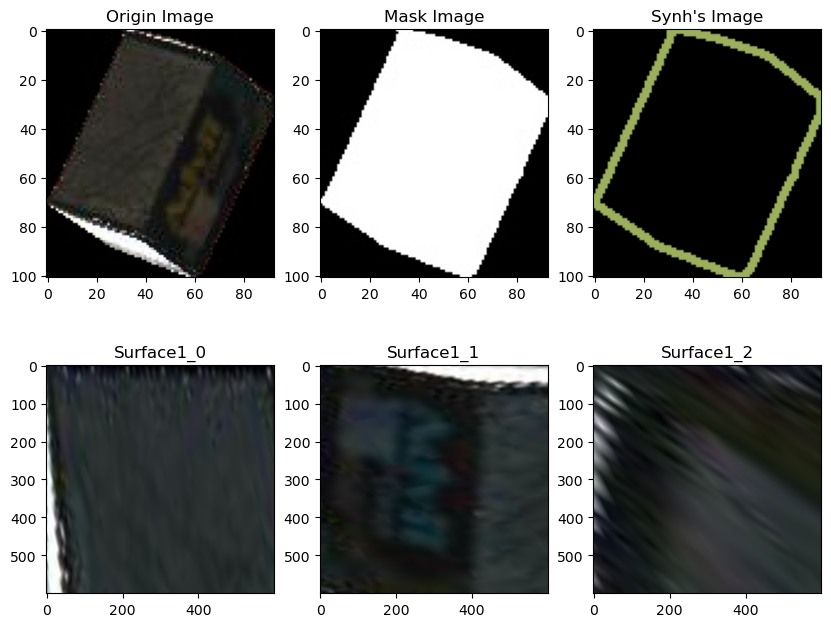

In [8]:
sample = []
sample.append(cv2.imread('classify/box/seg/00001_1.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_349.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_697.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_1241.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_2633.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_2865.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_10663.jpg'))

name = '00001_37566.jpg'
test_matching(name, sample)

In [11]:
data_path = 'classify/box/seg/'
object_images = {}
for file_name in os.listdir(data_path):
    # Split the file name to get the object id and the perspective id
    object_id, perspective_id = file_name.split('_')

    # Check if the object id already exists in the dictionary
    if object_id not in object_images:
        # If it does not exist, create a new entry in the dictionary with an empty list
        object_images[object_id] = []

    object_images[object_id].append(perspective_id)

In [12]:
import json

file_path = 'classify/box/my_dict.txt'

# Save the dictionary to the file
with open(file_path, 'w') as file:
    json.dump(object_images, file)

In [14]:
rng.sample(object_images['00001'], 20)

['10547.jpg',
 '97692.jpg',
 '13215.jpg',
 '40551.jpg',
 '111832.jpg',
 '92727.jpg',
 '25693.jpg',
 '20639.jpg',
 '114152.jpg',
 '78201.jpg',
 '50179.jpg',
 '11243.jpg',
 '109048.jpg',
 '73036.jpg',
 '105929.jpg',
 '108584.jpg',
 '79322.jpg',
 '2749.jpg',
 '38811.jpg',
 '113340.jpg']

In [18]:
data_path = 'classify/box/seg/'
sample = []
sample.append(cv2.imread('classify/box/seg/00001_1.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_349.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_697.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_1241.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_2633.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_2865.jpg'))
sample.append(cv2.imread('classify/box/seg/00001_10663.jpg'))

for file_name in os.listdir(data_path)[:10]:
    print(file_name)
    object = file_name.split('_')[0]
    name = file_name.split('.')[0]
    src_img = cv_imread(data_path+file_name)
    img = cv_imread('classify/box/label/'+file_name)

    # sample_id = rng.sample(object_images[object], 20)
    # sample_img = []
    # for _id in sample_id:
    #     sample_img.append(cv2.imread('classify/box/seg/'+object+'_'+_id))

    corners = check_shape(img)
    count = [0, 0]
    if len(corners[0]) == 6:
        cut = cut_img_matching(src_img, corners[0], sample)
        cv2.imwrite('classify/box/crop_by_matching/croped/'+name+'_0.jpg', cut[0])
        cv2.imwrite('classify/box/crop_by_matching/croped/'+name+'_1.jpg', cut[1])
        cv2.imwrite('classify/box/crop_by_matching/croped/'+name+'_2.jpg', cut[2])

print('Done!!!')

00001_1.jpg
00001_100012.jpg
00001_100128.jpg
00001_100244.jpg
00001_100360.jpg
00001_100476.jpg
00001_100592.jpg
00001_100708.jpg
00001_100824.jpg
00001_10083.jpg
Done!!!


In [23]:
pygame.init()

# creating display
X = 244*3
Y = 244*3

# create the display surface object
# of specific dimension..e(X, Y).
scrn = pygame.display.set_mode((X, Y))

# set the pygame window name
pygame.display.set_caption('image')

img_index = 0
img_pos = 1
status = True
count = [0, 0]
pic_status = [0, 0]
output_path = 'classify/box/crop/'

while status:
    file = os.listdir('classify/box/seg/')[img_index]
    src_img = cv_imread('classify/box/seg/'+file)
    img = cv_imread('classify/box/label/'+file)
    corners = check_shape(img)
    plt.set_cmap("gray")

    if len(corners[0]) == 6:
        cut= cut_img_surface(img, src_img, corners[0])
        # concatenate image Horizontally

        hori_1 = np.concatenate([cv2.resize(src_img, dsize = (244,244)), cv2.resize(img, dsize = (244,244)), cv2.resize(corners[1], dsize = (244,244))], axis=0)

        if cut != 0:
            hori_2 = np.concatenate([cv2.resize(cut[0], dsize = (244,244)), cv2.resize(cut[1], dsize = (244,244)), cv2.resize(cut[2], dsize = (244,244))], axis = 0)
            output = np.concatenate([hori_1, hori_2], axis= 1)[:,:,::-1]
            pic_status[0] = 1
        else:
            output = hori_1
            pic_status[1] = 1



        surf = pygame.surfarray.make_surface(output)
        scrn.blit(surf, (0, 0))
        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                status = False

            # checking if keydown event happened or not
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RIGHT:
                    img_index+=1
                    count[0] += pic_status[0]
                    count[1] += pic_status[1]
                    pic_status = [0, 0]
                    print("identified: {g}, don't know: {no}".format(g =count[0], no = count[1]))

    else:
        img_index+=1


pygame.quit()

identified: 1, don't know: 0
identified: 2, don't know: 0
identified: 3, don't know: 0
identified: 4, don't know: 0
identified: 5, don't know: 0
identified: 6, don't know: 0
identified: 6, don't know: 1
identified: 6, don't know: 2
identified: 7, don't know: 2
identified: 8, don't know: 2
identified: 8, don't know: 3
identified: 8, don't know: 4
identified: 9, don't know: 4
identified: 10, don't know: 4
identified: 11, don't know: 4
identified: 11, don't know: 5
identified: 11, don't know: 6
identified: 11, don't know: 7
identified: 11, don't know: 8
identified: 11, don't know: 9
identified: 11, don't know: 10
identified: 12, don't know: 10
identified: 12, don't know: 11
identified: 13, don't know: 11
identified: 13, don't know: 12
identified: 13, don't know: 13
identified: 14, don't know: 13
identified: 15, don't know: 13
identified: 16, don't know: 13
identified: 17, don't know: 13
identified: 18, don't know: 13
identified: 19, don't know: 13
identified: 20, don't know: 13
identified

<Figure size 640x480 with 0 Axes>

In [77]:
import pygame
import os
import cv2

pygame.init()

# creating display
X = 244*3
Y = 244*3

# create the display surface object
# of specific dimension..e(X, Y).
scrn = pygame.display.set_mode((X, Y))
GRAY_COLOR = 128
# set the pygame window name
pygame.display.set_caption('image')

img_index = 0
img_pos = 1
status = True
output_path = 'classify/box/crop/'

while status:
    file = os.listdir('classify/box/seg/')[img_index]
    src_img = cv_imread('classify/box/seg/'+file)
    img = cv_imread('classify/box/label/'+file)
    corners = check_shape(img)
    plt.set_cmap("gray")

    if len(corners[0]) == 6:
        cut = cut_img_surface(img, src_img, corners[0])
        # concatenate image Horizontally

        hori_1 = np.concatenate([cv2.resize(src_img, dsize = (244,244)), cv2.resize(img, dsize = (244,244)), cv2.resize(corners[1], dsize = (244,244))], axis=0)
        hori_2 = np.concatenate([cv2.resize(cut[0][0], dsize = (244,244)), cv2.resize(cut[0][1], dsize = (244,244)), cv2.resize(cut[0][2], dsize = (244,244))], axis = 0)
        hori_3 = np.concatenate([cv2.resize(cut[1][0], dsize = (244,244)), cv2.resize(cut[1][1], dsize = (244,244)), cv2.resize(cut[1][2], dsize = (244,244))], axis = 0)

        hori_1 = cv2.cvtColor(hori_1, cv2.COLOR_RGB2GRAY)
        output = np.concatenate([hori_1, hori_2, hori_3], axis= 1)


        surf = pygame.surfarray.make_surface(output)
        scrn.blit(surf, (0, 0))

        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                status = False

            # checking if keydown event happened or not
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RIGHT:
                    img_index+=1
                    print(file)
                if event.key == pygame.K_LEFT:
                    print()

    else:
        img_index+=1


pygame.quit()

<Figure size 640x480 with 0 Axes>

In [153]:
files = os.listdir('classify/box/seg/')[:1000]
count = [0,0]
for f in files:
    src_img = cv_imread('classify/box/seg/'+f)
    img = cv_imread('classify/box/label/'+f)
    object = f.split('.')[0]
    corners = check_shape(img)

    if len(corners[0]) == 6:
        cut= cut_img_surface(img, src_img, corners[0])
        if cut != 0:
            count[0] +=1
            cv2.imwrite('classify/box/crop_by_surface_2/identified/'+f, src_img)
            cv2.imwrite('classify/box/crop_by_surface_2/croped/'+object+'_0.jpg', cut[0])
            cv2.imwrite('classify/box/crop_by_surface_2/croped/'+object+'_1.jpg', cut[1])
            cv2.imwrite('classify/box/crop_by_surface_2/croped/'+object+'_2.jpg', cut[2])
        else:
            count[1] +=1
            cv2.imwrite('classify/box/crop_by_surface_2/no_identified/'+f, src_img)
print("identified: {g}, don't know: {no}".format(g =count[0], no = count[1]))


identified: 624, don't know: 78


In [211]:
files = os.listdir('classify/box/seg/')[:1000]
save_path = 'classify/box/crop_by_surface_4/'
count = [0,0,0]
for f in files:
    src_img = cv_imread('classify/box/seg/'+f)
    img = cv_imread('classify/box/label/'+f)
    object = f.split('.')[0]
    corners = check_shape(img)

    if len(corners[0]) == 6:
        cut= cut_img_surface(img, src_img, corners[0])
        if cut != 0:
            count[0] +=1
            cv2.imwrite(save_path + 'identified/'+f, src_img)
            cv2.imwrite(save_path + 'crop/'+object+'_0.jpg', cut[0])
            cv2.imwrite(save_path + 'crop/'+object+'_1.jpg', cut[1])
            cv2.imwrite(save_path + 'crop/'+object+'_2.jpg', cut[2])
        else:
            count[1] +=1
            cv2.imwrite(save_path + 'no_identified/'+f, src_img)
    else:
        count[2] +=1
        cv2.imwrite(save_path + 'others/'+f, src_img)
print("identified: {g}, don't know: {no}, others: {ot}".format(g =count[0], no = count[1], ot = count[2]))


identified: 630, don't know: 72, others: 298
